This notebook combines all features into one large model. 

In [1]:
model_name = "patch_tst_medium" + "_model_files"

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from autogluon.common import space
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import pickle

In [3]:
module_path = os.path.abspath(os.path.join('../..', 'utils'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ml_tools import add_weekends_holidays

d:\CS\summer_project\comp47360-group8\ml_pipeline\utils


In [4]:
# Turn off GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [5]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness', 'location':'item_id', 'datetime': 'timestamp'},axis=1, inplace=True)
print(df.columns)

Index(['timestamp', 'item_id', 'busyness'], dtype='object')


In [6]:
df['day'] = df['timestamp'].dt.day_name().str.lower()
df['hour'] = df['timestamp'].dt.hour

In [7]:
df.shape

(7696641, 5)

In [8]:
df.head()

,timestamp,item_id,busyness,day,hour
0,2021-01-01,3,132,friday,0
1,2021-01-01,4,234,friday,0
2,2021-01-01,5,19,friday,0
3,2021-01-01,6,37,friday,0
4,2021-01-01,7,493,friday,0


In [9]:
df_open = pd.read_csv("../../data_preparation/taxi_location_num_businesses_open/taxi_location_num_businesses_open.csv")
df_open.rename({'location':'item_id'},axis=1, inplace=True)


In [10]:
df

,timestamp,item_id,busyness,day,hour
0,2021-01-01,3,132,friday,0
1,2021-01-01,4,234,friday,0
2,2021-01-01,5,19,friday,0
3,2021-01-01,6,37,friday,0
4,2021-01-01,7,493,friday,0
...,...,...,...,...,...
7696636,2024-06-01,239,2,saturday,0
7696637,2024-06-01,249,1,saturday,0
7696638,2024-06-01,255,2,saturday,0
7696639,2024-06-01,262,1,saturday,0


In [11]:
df = df.join(df_open.set_index(['day', 'hour', 'item_id']), on=['day', 'hour', 'item_id'])

In [12]:
df.fillna({'alcohol':0, 'food':0, 'leisure':0}, inplace=True)

In [13]:
df.drop(['day', 'hour'], axis=1, inplace=True)

In [14]:
df.head()

,timestamp,item_id,busyness,food,alcohol,leisure
0,2021-01-01,3,132,0.0,0.0,0.0
1,2021-01-01,4,234,0.0,0.0,0.0
2,2021-01-01,5,19,0.0,0.0,0.0
3,2021-01-01,6,37,0.0,0.0,0.0
4,2021-01-01,7,493,0.0,0.0,0.0


In [15]:
df_wth = pd.read_csv("../../data_evaluation/weather_meteostat/meteostat_weather.csv")
df_wth.rename({'time':'timestamp'}, axis=1,inplace=True)
df_wth['timestamp'] = df_wth['timestamp'].astype('datetime64[us]')
df_wth['timestamp'] = pd.to_datetime(df_wth['timestamp'])
df_wth['coco'] = df_wth['coco'].astype('category')
df_wth.sort_values(by=['timestamp'])
df = df.join(df_wth.set_index('timestamp'), on='timestamp', how='left')

In [16]:
static_features_df = pd.read_csv("../../data_evaluation/taxi_trip_data/taxi_zone_lookup.csv")
static_features_df.rename({'LocationID': 'item_id'}, axis=1, inplace=True)

In [17]:
df = df[df['item_id'].isin(static_features_df.loc[static_features_df['Borough']=="Manhattan", 'item_id'])]

In [18]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df = static_features_df
)
data = data.sort_index()
data = data.fill_missing_values()

In [19]:
add_weekends_holidays(data)

In [20]:
pkl_file_path = "patch_tst_small_df.pkl"
with open(pkl_file_path, 'wb') as f:
    pickle.dump(data, f)

In [21]:
data.head()

busyness  food  alcohol  leisure  temp  dwpt  \
item_id timestamp                                                           
4       2021-01-01 00:00:00       234   0.0      0.0      0.0   4.0  -4.0   
        2021-01-01 01:00:00       315   1.0      0.0      0.0   3.0  -4.0   
        2021-01-01 02:00:00       263   1.0      0.0      0.0   3.0  -4.0   
        2021-01-01 03:00:00       216   1.0      0.0      0.0   2.0  -3.9   
        2021-01-01 04:00:00       130   1.0      0.0      0.0   2.0  -5.0   

                             rhum  prcp    pres coco  weekend  holiday  
item_id timestamp                                                       
4       2021-01-01 00:00:00  56.0   0.0  1026.3  4.0      0.0      1.0  
        2021-01-01 01:00:00  60.0   0.0  1027.7  4.0      0.0      1.0  
        2021-01-01 02:00:00  60.0   0.0  1028.1  4.0      0.0      1.0  
        2021-01-01 03:00:00  65.0   0.0  1029.2  3.0      0.0      1.0  
        2021-01-01 04:00:00  60.0   0.0  1029.9  3.0      0.0      1.0

In [22]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [23]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    quantile_levels=[0.5],
    eval_metric="MASE",
    prediction_length=prediction_length,
    path=model_name,
    known_covariates_names=['food', 'alcohol', 'leisure', 'weekend', 'holiday', 'temp', 'dwpt', 'rhum', 'prcp', 'pres', 'coco']
)
print('we made the predictor')

we made the predictor


In [24]:
predictions = predictor.fit(test_data,
                                hyperparameters= {"PatchTST": {
                                    "context_length":192,
                                    "num_encoder_layers":4,
                                    "batch_size": 1024,
                                    "batches_per_epoch": 400
                                }},
                                refit_full=True
                                # excluded_model_types=["Chronos", "RecursiveTabular", "NPTS", "DeepAR", "AutoARIMA", "AutoETS", "DirectTabular", "DeepAR"]
                                
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'patch_tst_medium_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          0
Memory Avail:       8.53 GB / 15.90 GB (53.6%)
Disk Space Avail:   2018.31 GB / 2794.50 GB (72.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'PatchTST': {'batch_size': 1024,
                                  'batches_per_epoch': 400,
                                  'context_length': 192,
                                  'num_encoder_layers': 4}},
 'known_covariates_names': ['food',
                            'alcohol',
                            'leisure',
                            'weekend',
                            'holiday',
                            'temp',
                          

In [25]:
predictor = TimeSeriesPredictor.load(model_name)

Loading predictor from path patch_tst_medium_model_files


In [26]:
print(predictor.leaderboard())

           model  score_val  pred_time_val  fit_time_marginal  fit_order
0       PatchTST  -0.653353       0.756948       10075.367407          1
1  PatchTST_FULL        NaN            NaN       10073.929333          2


In [27]:
future_index = get_forecast_horizon_index_ts_dataframe(test_data, prediction_length=prediction_length, freq='H')
future_timestamps = future_index.get_level_values("timestamp").to_series()


c:\Users\Daniel\miniconda3\envs\comp47360_autogluon\lib\site-packages\autogluon\timeseries\utils\forecast.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [28]:
known_covariates = pd.DataFrame(index=future_index)

In [29]:
known_covariates['hour'] = future_timestamps.dt.hour.to_list()

In [30]:
known_covariates['day'] = future_timestamps.dt.day_name().str.lower().values
known_covariates['hour'] = future_timestamps.dt.hour.to_list()
known_covariates = known_covariates.join(df_open.set_index(['day', 'hour', 'item_id']), on=['day', 'hour', 'item_id'])
known_covariates = known_covariates.join(df_wth.set_index("timestamp"), on='timestamp', how='left')
add_weekends_holidays(known_covariates)

In [31]:
known_covariates.loc[4]

,hour,day,food,alcohol,leisure,temp,dwpt,rhum,prcp,pres,coco,weekend,holiday
timestamp,,,,,,,,,,,,,
2024-06-01 01:00:00,1,saturday,1.0,0.0,0.0,21.1,5.0,35.0,0.0,1020.6,1.0,1.0,0.0
2024-06-01 02:00:00,2,saturday,1.0,0.0,0.0,20.6,3.8,33.0,0.0,1020.9,3.0,1.0,0.0
2024-06-01 03:00:00,3,saturday,1.0,0.0,0.0,19.0,5.1,40.0,0.0,1022.0,1.0,1.0,0.0
2024-06-01 04:00:00,4,saturday,1.0,0.0,0.0,18.9,4.3,38.0,0.0,1021.1,1.0,1.0,0.0
2024-06-01 05:00:00,5,saturday,1.0,0.0,0.0,17.8,5.1,43.0,0.0,1020.7,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-29 20:00:00,20,thursday,16.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-08-29 21:00:00,21,thursday,14.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2024-08-29 22:00:00,22,thursday,7.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [32]:
predictions = predictor.predict(test_data, known_covariates=known_covariates)

print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: PatchTST_FULL


                                   mean         0.5
item_id timestamp                                  
4       2024-06-01 01:00:00  146.931366  146.931366
        2024-06-01 02:00:00  135.236755  135.236755
        2024-06-01 03:00:00   86.441528   86.441528
        2024-06-01 04:00:00   58.496201   58.496201
        2024-06-01 05:00:00   50.360954   50.360954
...                                 ...         ...
263     2024-08-29 19:00:00  796.105835  796.105835
        2024-08-29 20:00:00  773.023071  773.023071
        2024-08-29 21:00:00  814.645630  814.645630
        2024-08-29 22:00:00  794.418640  794.418640
        2024-08-29 23:00:00  643.123596  643.123596

[149040 rows x 2 columns]


data with frequency 'None' has been resampled to frequency 'h'.


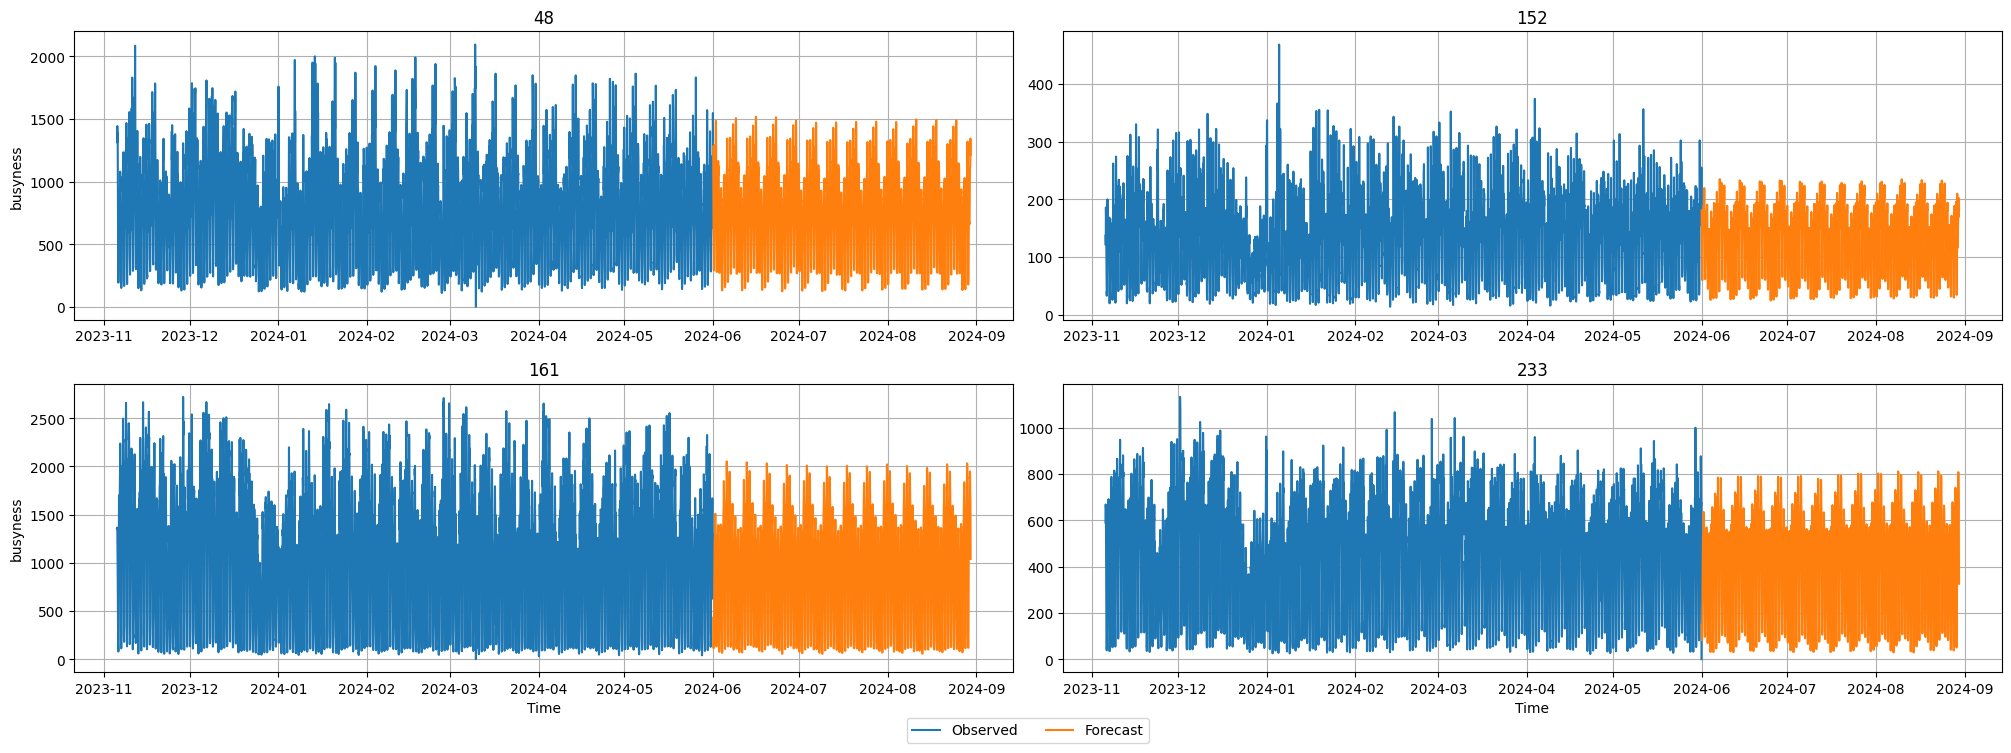

In [33]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


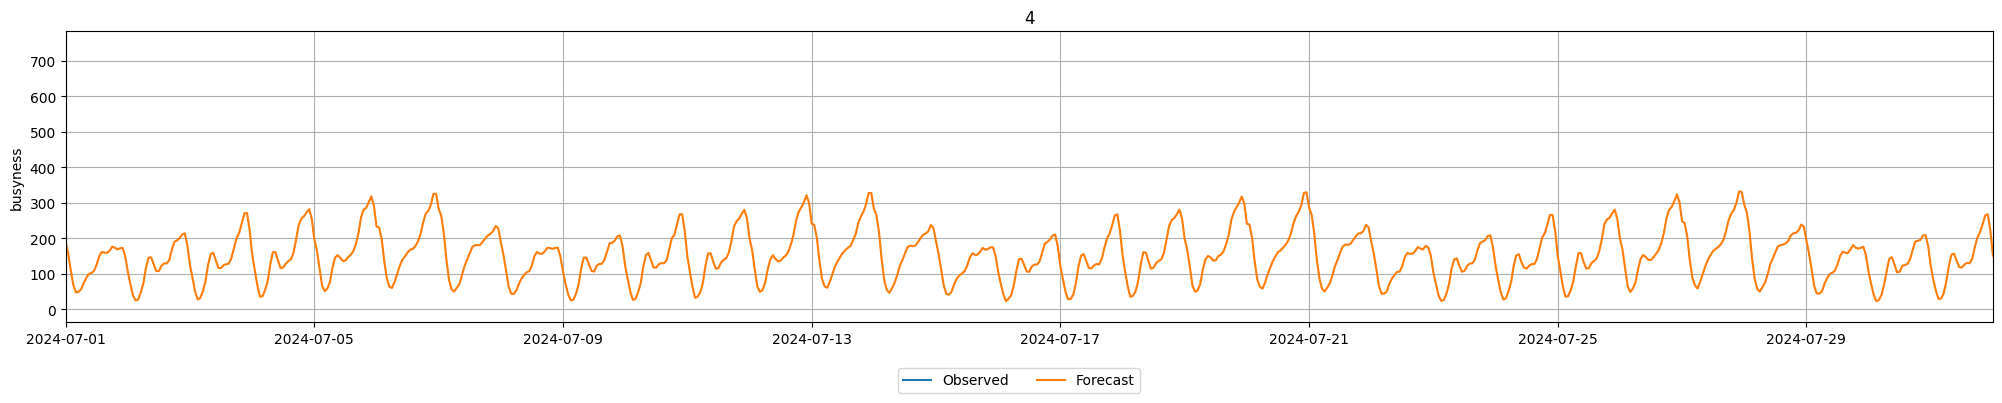

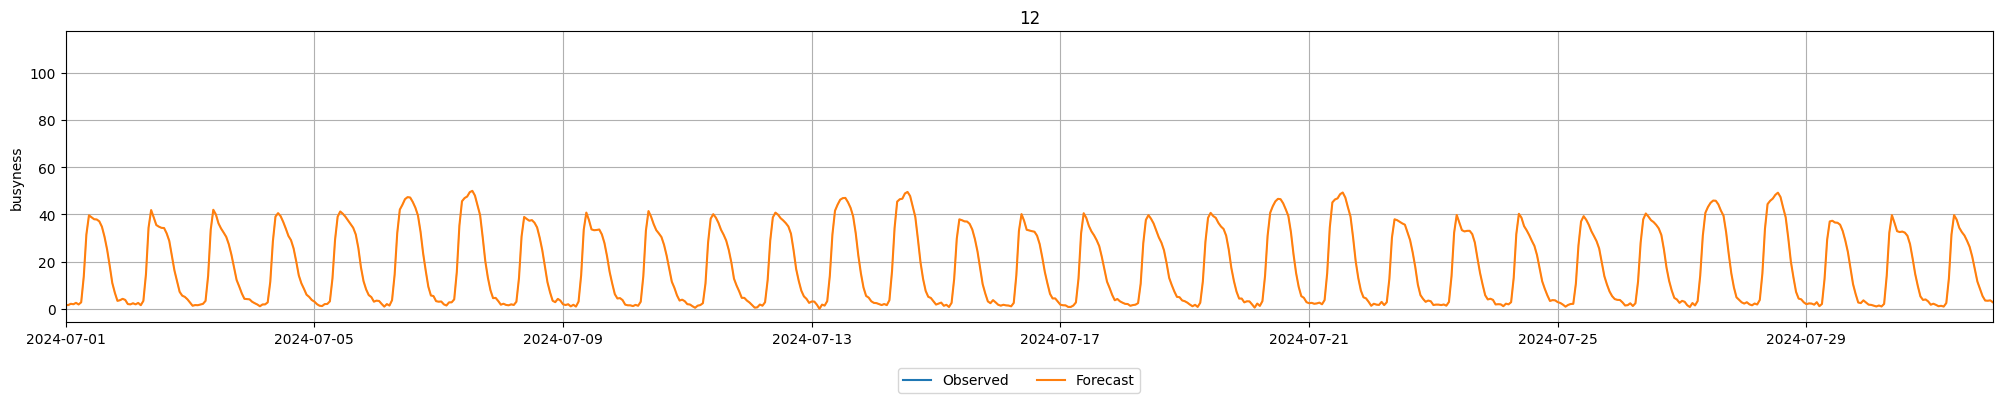

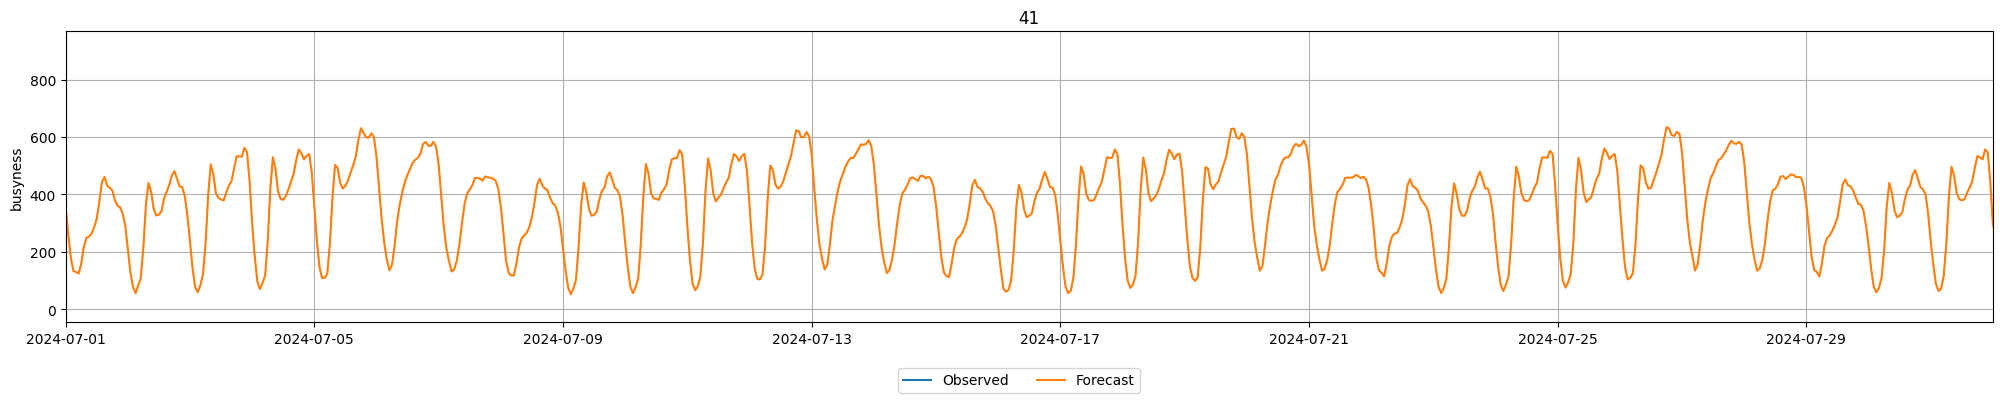

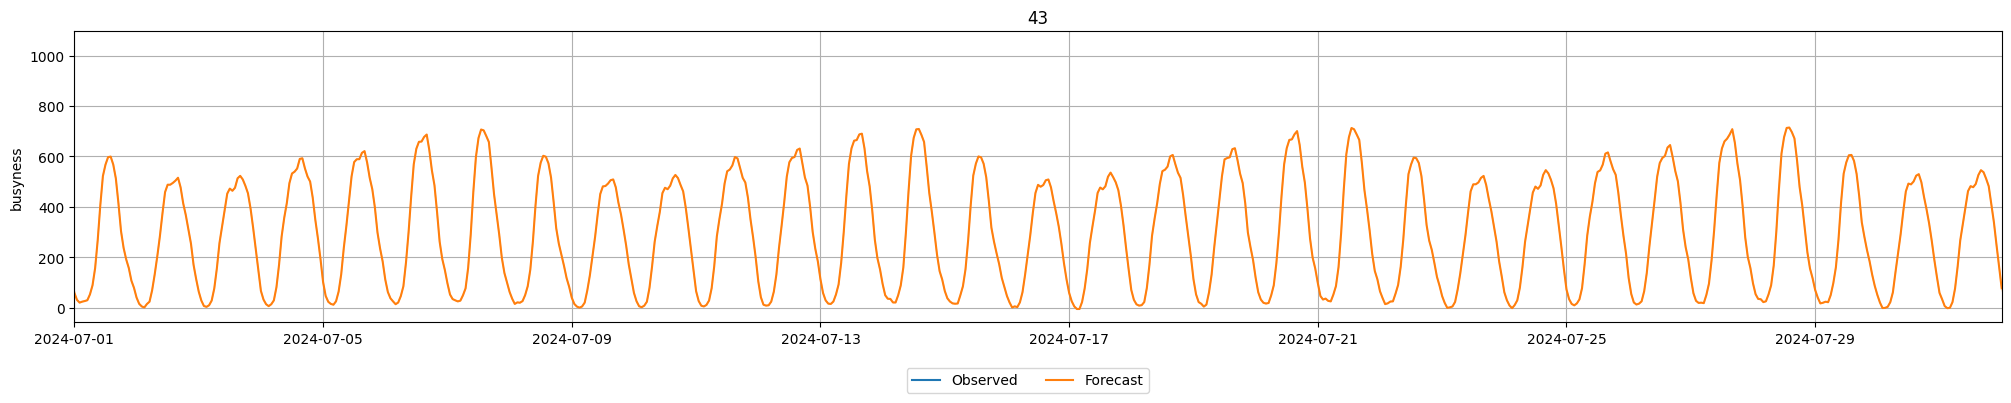

In [34]:
xmin = pd.Timestamp('2024-07-01 00:00:00')
xmax = pd.Timestamp('2024-07-31 23:59:59')
item_ids = [4, 12, 41, 43]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [35]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: PatchTST_FULL


{'MASE': -0.6533527234580774}

In [36]:
# data.loc[111]